In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from sklearn.metrics import roc_auc_score
from sklearn import mixture, preprocessing, datasets

from importlib import reload
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches

import torch.utils.data as data_utils

import utils.models as models
import utils.plotting as plotting
import utils.dataloaders as dl
import utils.traintest as tt
import utils.adversarial as adv
import utils.eval as ev
import model_params as params
import utils.resnet_orig as resnet
import utils.gmm_helpers as gmm_helpers

import model_paths

In [94]:
device = torch.device('cuda:1')
dataset = 'CIFAR100'

file_dict = {'MNIST' :'samples_steps200_alpha3.0_restarts10_batches10_batch_size100_MNIST_2019-05-23 08:04:35.125721_MNIST.pth',
             'FMNIST':'samples_steps200_alpha3.0_restarts10_batches10_batch_size100_FMNIST_2019-05-23 08:04:29.726413_FMNIST.pth',
             'SVHN' : 'samples_steps200_alpha3.0_restarts10_batches10_batch_size100_SVHN_2019-05-23 08:04:24.698078_SVHN.pth',
             'CIFAR10':'samples_steps200_alpha3.0_restarts10_batches10_batch_size100_CIFAR10_2019-05-23 08:04:19.157633_CIFAR10.pth',
             'CIFAR100' : 'samples_steps200_alpha3.0_restarts10_batches10_batch_size100_CIFAR100_2019-05-23 08:04:16.923633_CIFAR100.pth'
            }

file = file_dict[dataset]

batch = torch.load('results/backup/' + file)

model_params = params.params_dict[dataset]()
model_path = model_paths.model_dict[dataset]() 
model_list = [torch.load(file).cpu() for file in model_path.files]

Using downloaded and verified file: ../data/test_32x32.mat


/usr/local/lib/python3.5/dist-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.5/dist-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.5/dist-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `

In [95]:


if dataset in ['MNIST', 'FMNIST']:
    noise = batch.samples.transpose(0,1).contiguous().view(4, 1000, 1, 28, 28)
elif dataset in ['CIFAR10', 'SVHN', 'CIFAR100']:
    noise = batch.samples.transpose(0,1).contiguous().view(4, 1000, 3, 32, 32)
    
noise_list = []
for i in range(4):
    noise_list.append(noise[i])

In [96]:
Y = [model(no).max(1) for (no, model) in zip(noise_list, model_list)]
conf = [y[0][0].exp().item() for y in Y]
pred = [y[1][0].item() for y in Y]

In [97]:
conf = torch.stack([y[0] for y in Y], 0)
index = conf.exp().sum(0).argmax()
#index = 10

if dataset in ['MNIST', 'FMNIST']:
    seed = batch.seeds.view(-1,1,28,28)[index]
elif dataset in ['CIFAR10', 'SVHN', 'CIFAR100']:
    seed = batch.seeds.view(-1,3,32,32)[index]

adv_noise = noise[:,index]

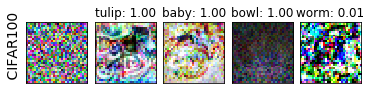

In [98]:
plt.subplot(1, 5, 1)
plt.ylabel(' ' + dataset + '\n', rotation=90, horizontalalignment='left', va='center',
          fontsize=14, position=(0,0))

if dataset in ['MNIST', 'FMNIST']:
    plt.imshow(seed.squeeze().detach().cpu(), cmap='gray', interpolation='none')
elif dataset in ['CIFAR10', 'SVHN', 'CIFAR100']:
    plt.imshow(seed.transpose(0,2).transpose(0,1).detach().cpu(), interpolation='none')

plt.xticks([])
plt.yticks([])

for i in range(4):
    plt.subplot(1, 5, 2 + i)

    if dataset in ['MNIST', 'SVHN']:
        string = model_path.keys[i] + '\n'
    else:
        string = ''

    string += ( str(plotting.classes_dict[dataset][pred[i]] )
               + ": %.2f" % conf[i][index].exp().item() )

    #plt.title(string, fontsize='small')
    plt.title(string)

    if dataset in ['MNIST', 'FMNIST']:
        plt.imshow(adv_noise[i].squeeze().detach().cpu(), cmap='gray', interpolation='none')
    elif dataset in ['CIFAR10', 'SVHN', 'CIFAR100']:
        plt.imshow(adv_noise[i].transpose(0,2).transpose(0,1).detach().cpu(), interpolation='none')
    plt.xticks([])
    plt.yticks([])
    
# plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.12, hspace=None)
myplot = plt.gcf()

In [99]:
myplot.savefig('results/' + dataset + '_sample' + '.eps', format='eps', 
               bbox_inches = 'tight', pad_inches = 0)